# Correlation Analysis
---

In [1]:
import itertools
from itertools import combinations_with_replacement
from datetime import datetime, timedelta

import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
import math
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

%load_ext nb_black

<IPython.core.display.Javascript object>

## Preprocessing
***

In [2]:
def cast_to_datetime(df, col):
    return df[col].astype("datetime64[ns]")


def cast_to_datetime_all(df_polls, candidates, newspapers, candidates_name):
    df_polls["Date_start"] = cast_to_datetime(df_polls, "Date_start")
    df_polls["Date_end"] = cast_to_datetime(df_polls, "Date_end")
    
    for df_candidate in candidates:
        df_candidate["date"] = cast_to_datetime(df_candidate, "date")
    
    for df_newspaper in newspapers:
        df_newspaper["date"] = cast_to_datetime(df_newspaper, "date")
    
    return {"polls": df_polls, "candidates":  candidates, "newspapers": newspapers, "names": candidates_name}

<IPython.core.display.Javascript object>

In [3]:
# Change to false if you don't want to load a certain year
flag_2012 = True
flag_2016 = True
flag_2020 = True

## Load data
PATH_2012 = "DATA\\2012\\"
PATH_2016 = "DATA\\2016\\"
PATH_2020 = "DATA\\2020\\"
PATH_PREPROCESSED = "Data\\preprocessed\\"

data = []

if flag_2012:  
    df_polls_2012 = pd.read_csv(PATH_PREPROCESSED + "polls_2012.csv")
    
    df_sentiment_obama_2012 = pd.read_csv(PATH_PREPROCESSED + "sentiment_obama_2012.csv")
    df_sentiment_romney_2012 = pd.read_csv(PATH_PREPROCESSED + "sentiment_romney_2012.csv")
    
    candidates_2012 = [df_sentiment_obama_2012, df_sentiment_romney_2012]
    
    df_bbc_2012 = pd.read_csv(PATH_2012 + "bbc_2012.zip")
    df_foxnews_2012 = pd.read_csv(PATH_2012 + "foxnews_2012.zip")
    df_nytimes_2012 = pd.read_csv(PATH_2012 + "ny_times_2012.zip")
    
    newspaper_2012 = [df_bbc_2012, df_foxnews_2012, df_nytimes_2012]
    
    data.append(("2012", cast_to_datetime_all(df_polls_2012, candidates_2012, newspaper_2012, ["Obama", "Romney"])))
    
if flag_2016:
    df_polls_2016 = pd.read_csv(PATH_PREPROCESSED + "polls_2016.csv")
    
    df_sentiment_clinton_2016 = pd.read_csv(PATH_PREPROCESSED + "sentiment_clinton_2016.csv")
    df_sentiment_trump_2016 = pd.read_csv(PATH_PREPROCESSED + "sentiment_trump_2016.csv")
    
    candidates_2016 = [df_sentiment_clinton_2016, df_sentiment_trump_2016]
    
    df_bbc_2016 = pd.read_csv(PATH_2016 + "bbc_2016.zip")
    df_foxnews_2016 = pd.read_csv(PATH_2016 + "foxnews_2016.zip")
    df_nytimes_2016 = pd.read_csv(PATH_2016 + "ny_times_2016.zip")
    
    newspaper_2016 = [df_bbc_2016, df_foxnews_2016, df_nytimes_2016]
    
    data.append(("2016", cast_to_datetime_all(df_polls_2016, candidates_2016, newspaper_2016, ["Clinton", "Trump"])))
    
if flag_2020:
    df_polls_2020 = pd.read_csv(PATH_PREPROCESSED + "polls_2020.csv")

    df_sentiment_biden_2020 = pd.read_csv(PATH_PREPROCESSED + "sentiment_biden_2020.csv")
    df_sentiment_trump_2020 = pd.read_csv(PATH_PREPROCESSED + "sentiment_trump_2020.csv")

    candidates_2020 = [df_sentiment_biden_2020, df_sentiment_trump_2020]
    
    df_bbc_2020 = pd.read_csv(PATH_2020 + "bbc_2020.zip")
    df_foxnews_2020 = pd.read_csv(PATH_2020 + "foxnews_2020.zip")
    df_nytimes_2020 = pd.read_csv(PATH_2020 + "ny_times_2020.zip")
    
    newspaper_2020 = [df_bbc_2020, df_foxnews_2020, df_nytimes_2020]
    
    data.append(("2020", cast_to_datetime_all(df_polls_2020, candidates_2020, newspaper_2020, ["Biden", "Trump"])))

<IPython.core.display.Javascript object>

### Aggregation

There are several timeframe levels (such as year, month, week and day) in which we can aggregate the results for each combination of election year, candidate, and newspaper.  
If we aggregate by year we will have 1 data point only, by month 12 data points at most and 3 in the worst case (because some months will be discarded due to the small amount of occurrences).  
Therefore, due to the lack of data we found that the best compromise between number of occurrences per period of time and the number of data points is achieved when we aggregate by week.  
The aggregation will be done as follows: take the mean of intention votes over the week (by choosing the end date of the poll to specify the week),  
and the occurrences will be rescaled by taking the occurrences of quotes for a specific combination over the week and dividing it by the total number of quotations in the specific week and newspaper.

In [4]:
def check_columns(newspaper, df_newspaper, df_candidate):
    check = True
    
    if "date" not in df_newspaper.columns:
        print("Error: missing 'date' column in df_newspaper")
        check = False
        
    if "date" not in df_candidate.columns:
        print("Error: missing 'date' column in df_candidate")
        check = False
        
    if "type" not in df_candidate.columns:
        print("Error: missing 'type' column in df_candidate")
        check = False
    elif newspaper not in df_candidate.type.unique():
        print(f"Error: newspaper '{newspaper}' is not in the list of newspapers")
        check = False
    
    return check;


def aggregate_by_week(df, col, operation):
    df = df.sort_values("date")
    df.loc[:, "week"] = df.loc[:, "date"].dt.strftime("%U")
    df_weekly_occurrences = df.groupby("week", as_index=False).agg({col : operation}).rename(columns={col : f"{col}_{operation}"})
    df_weekly_occurrences["week"] = df_weekly_occurrences["week"].astype("int64")
    
    return df_weekly_occurrences


def merge_occurrences(df_newspaper_occurrences, df_candidate_occurrences):
    df_counts = df_newspaper_occurrences.set_index("week").join(
        df_candidate_occurrences.set_index("week"),
        on="week",
        how="left",
        lsuffix="_newspaper",
        rsuffix="_candidate",
    )

    df_counts = df_counts[["date_count_newspaper", "date_count_candidate"]]
    df_counts["weekly_occurrences_rescaled"] = (df_counts["date_count_candidate"] / df_counts["date_count_newspaper"])
    
    return df_counts
    

def compute_weekly_rescaled_occurences_intention(newspaper, df_newspaper, df_candidate, df_polls, intention_idx = 0, keep_weeks = "all"):
    candidate = df_polls.columns[4 + intention_idx]
    
    print(f"Candidate: {candidate}, newspaper: {newspaper}")
    
    df_polls = df_polls.rename(columns={"Date_end" : "date", df_polls.columns[4 + intention_idx]: "intention"})
    
    if not check_columns(newspaper, df_newspaper, df_candidate):
        return
    
    df_newspaper_weekly_occurrences = aggregate_by_week(df_newspaper, "date", "count")
    df_candidate_weekly_occurrences = aggregate_by_week(df_candidate[df_candidate.type == newspaper], "date", "count")
    df_intention_weekly_averaged = aggregate_by_week(df_polls, "intention", "mean")
     
    df_counts = merge_occurrences(df_newspaper_weekly_occurrences, df_candidate_weekly_occurrences)
    
    df_occurrences_intention = df_counts.join(
        df_intention_weekly_averaged.set_index("week"),
        on="week",
        how="inner",
    )
     
    if keep_weeks != "all":
        keep_weeks = list(set(keep_weeks).intersection(set(df_occurrences_intention.index)))
        df_occurrences_intention = df_occurrences_intention.loc[keep_weeks, :]
    
    print(keep_weeks)

    return df_occurrences_intention[["weekly_occurrences_rescaled", "intention_mean"]].rename_axis('week').reset_index()

<IPython.core.display.Javascript object>

Here we will create a dictionary containing a dataframe (with variables intention_mean, weekly_occurrences_rescaled) for each combination of election year, candidate, and newspaper.  
It will be useful for the correlation analysis and can be accessed as follows: e.g. dict_wroi[("2012", "Obama", "BBC")]

In [5]:
dict_wroi = {}

for year in data:
    for intention_idx in [0, 1]:
        for newspaper_idx in [0, 1, 2]:
            df_polls = year[1]["polls"]

            df_candidate = year[1]["candidates"][intention_idx]
            condidate_name = year[1]["names"][intention_idx]

            df_newspaper = year[1]["newspapers"][newspaper_idx]
            newspaper_name = ["BBC", "Fox News", "NY Times"][newspaper_idx]
            
            keep_weeks = "all"
            
            if year[0] == "2016":
                start_dt = datetime(2016, 7, 1)
                end_dt = datetime(2016, 9, 30)
                keep_weeks = list(range(int(start_dt.strftime("%U")), int(end_dt.strftime("%U"))+1))
            elif year[0] == "2020":
                start_dt = datetime(2020, 1, 1)
                end_dt = datetime(2020, 4, 30)
                keep_weeks = list(range(int(start_dt.strftime("%U")), int(end_dt.strftime("%U"))+1))

            dict_wroi[
                (year[0], condidate_name, newspaper_name)
            ] = compute_weekly_rescaled_occurences_intention(
                newspaper_name,
                df_newspaper[["date"]],
                df_candidate[["type", "date"]],
                df_polls,
                intention_idx,
                keep_weeks
            )

Candidate: Obama (D), newspaper: BBC
all
Candidate: Obama (D), newspaper: Fox News
all
Candidate: Obama (D), newspaper: NY Times
all
Candidate: Romney (R), newspaper: BBC
all
Candidate: Romney (R), newspaper: Fox News
all
Candidate: Romney (R), newspaper: NY Times
all
Candidate: Clinton (D), newspaper: BBC
[32, 33, 34, 35, 36, 37, 38, 39, 26, 27, 28, 29, 30, 31]
Candidate: Clinton (D), newspaper: Fox News
[32, 33, 34, 35, 36, 37, 38, 39, 26, 27, 28, 29, 30, 31]
Candidate: Clinton (D), newspaper: NY Times
[32, 33, 34, 35, 36, 37, 38, 39, 26, 27, 28, 29, 30, 31]
Candidate: Trump (R), newspaper: BBC
[32, 33, 34, 35, 36, 37, 38, 39, 26, 27, 28, 29, 30, 31]
Candidate: Trump (R), newspaper: Fox News
[32, 33, 34, 35, 36, 37, 38, 39, 26, 27, 28, 29, 30, 31]
Candidate: Trump (R), newspaper: NY Times
[32, 33, 34, 35, 36, 37, 38, 39, 26, 27, 28, 29, 30, 31]
Candidate: Biden (D), newspaper: BBC
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Candidate: Biden (D), newspaper: Fox News
[0, 1, 2, 

<IPython.core.display.Javascript object>

Here we combine all the dataframes together to simplify the analysis between different elections and candidates.

In [6]:
df_all = pd.DataFrame()
week_count = 0

for year in data:
    for intention_idx in [0, 1]:
        newspaper_count = 0
        
        for newspaper_idx in [0, 1, 2]:
            df_polls = year[1]["polls"]

            df_candidate = year[1]["candidates"][intention_idx]
            condidate_name = year[1]["names"][intention_idx]

            df_newspaper = year[1]["newspapers"][newspaper_idx]
            newspaper_name = ["BBC", "Fox News", "NY Times"][newspaper_idx]
            
            keep_weeks = "all"
            
            if year[0] == "2016":
                start_dt = datetime(2016, 7, 1)
                end_dt = datetime(2016, 9, 30)
                keep_weeks = list(range(int(start_dt.strftime("%U")), int(end_dt.strftime("%U"))+1))
            elif year[0] == "2020":
                start_dt = datetime(2020, 1, 1)
                end_dt = datetime(2020, 4, 30)
                keep_weeks = list(range(int(start_dt.strftime("%U")), int(end_dt.strftime("%U"))+1))
            
            df_temp = compute_weekly_rescaled_occurences_intention(
                newspaper_name,
                df_newspaper[["date"]],
                df_candidate[["type", "date"]],
                df_polls,
                intention_idx,
                keep_weeks
            )
            
            if week_count == 0:
                df_all["week"] = df_temp["week"]
                week_count += 1
            
            if newspaper_count == 0:
                df_all[f"intention_mean_{year[0]}_{condidate_name}"] = df_temp["intention_mean"]
            
            df_all[f"wor_{year[0]}_{condidate_name}_{newspaper_name}"] = df_temp["weekly_occurrences_rescaled"]

# Save data
# df_all.to_csv(f"Data\preprocessed\weekly_rescaled_occurences_intention.csv", index=False) 

# Load data
# PATH_PREPROCESSED = "Data\\preprocessed\\"
# df_all = pd.read_csv(PATH_PREPROCESSED + "weekly_rescaled_occurences_intention.csv")
# df_all.columns

Candidate: Obama (D), newspaper: BBC
all
Candidate: Obama (D), newspaper: Fox News
all
Candidate: Obama (D), newspaper: NY Times
all
Candidate: Romney (R), newspaper: BBC
all
Candidate: Romney (R), newspaper: Fox News
all
Candidate: Romney (R), newspaper: NY Times
all
Candidate: Clinton (D), newspaper: BBC
[32, 33, 34, 35, 36, 37, 38, 39, 26, 27, 28, 29, 30, 31]
Candidate: Clinton (D), newspaper: Fox News
[32, 33, 34, 35, 36, 37, 38, 39, 26, 27, 28, 29, 30, 31]
Candidate: Clinton (D), newspaper: NY Times
[32, 33, 34, 35, 36, 37, 38, 39, 26, 27, 28, 29, 30, 31]
Candidate: Trump (R), newspaper: BBC
[32, 33, 34, 35, 36, 37, 38, 39, 26, 27, 28, 29, 30, 31]
Candidate: Trump (R), newspaper: Fox News
[32, 33, 34, 35, 36, 37, 38, 39, 26, 27, 28, 29, 30, 31]
Candidate: Trump (R), newspaper: NY Times
[32, 33, 34, 35, 36, 37, 38, 39, 26, 27, 28, 29, 30, 31]
Candidate: Biden (D), newspaper: BBC
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Candidate: Biden (D), newspaper: Fox News
[0, 1, 2, 

<IPython.core.display.Javascript object>

## Correlation Analysis
---

In [11]:
def baseline_model(df):
    df = df.dropna()

    col1 = 'weekly_occurrences_rescaled'
    col2 = 'intention_mean'
    
    spear_corr, spear_p = stats.spearmanr(df[col1], df[col2])
    
    return {"Spearmanr": spear_corr, "P-value": spear_p}

def plot_combination(y_var, title):
    sns.set(font_scale=1.2)
    ax = sns.catplot(data=df_correlation, x="Candidate", y=y_var, col="Year", kind="bar", hue="Newspaper", sharex=False)
    ax.fig.subplots_adjust(top=0.8) # adjust the Figure in rp
    ax.fig.suptitle(title, fontsize=20)
    plt.show()

<IPython.core.display.Javascript object>

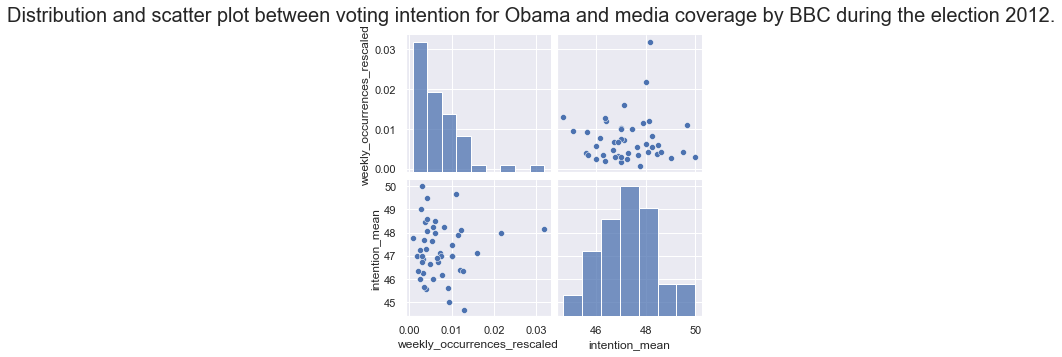

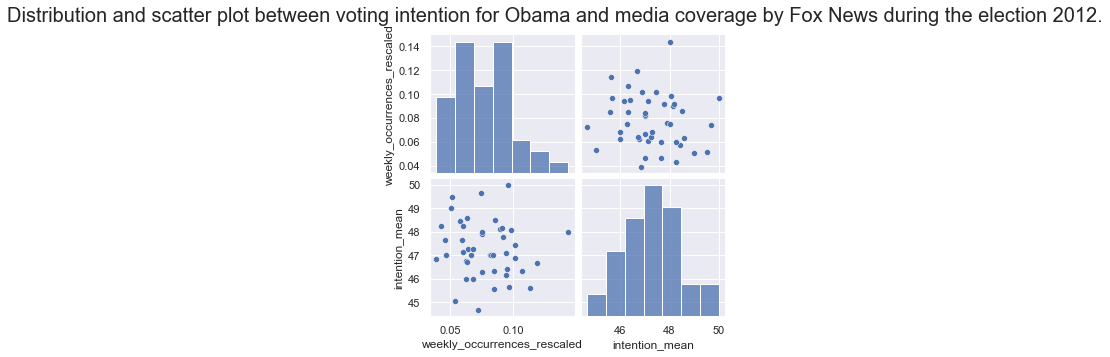

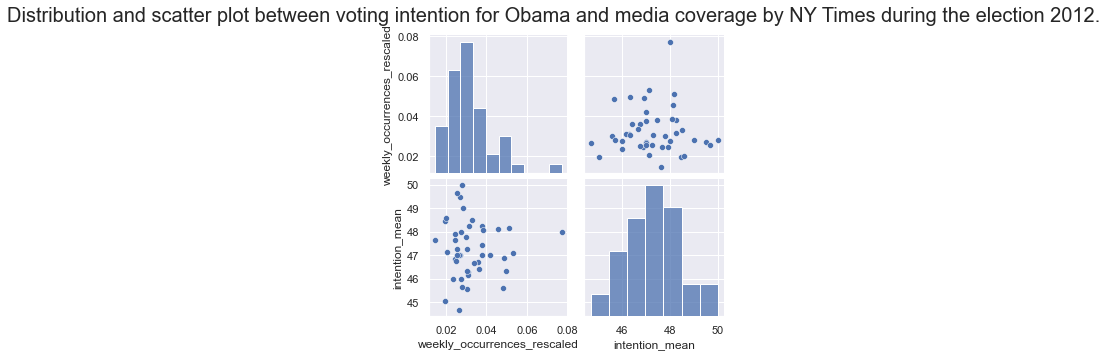

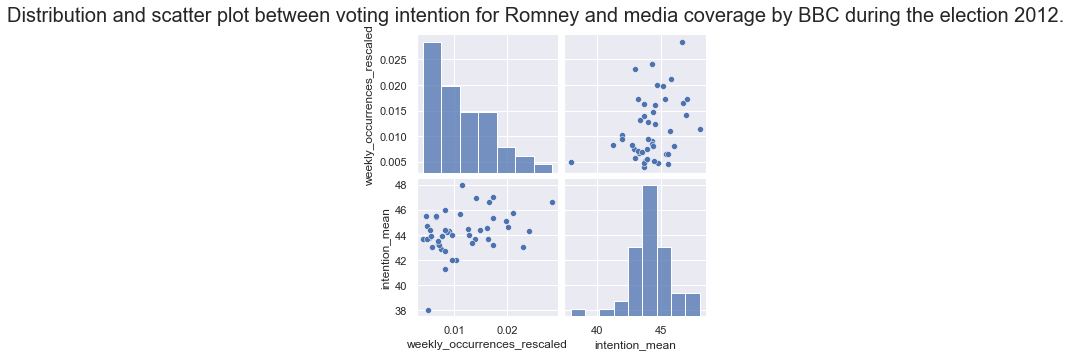

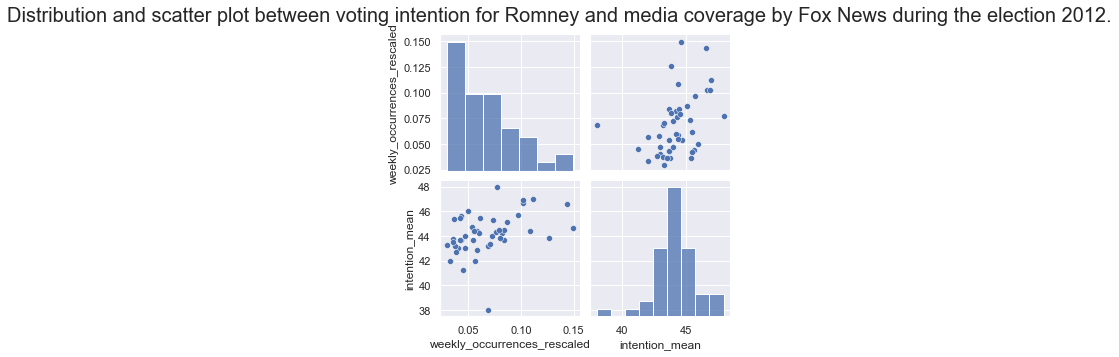

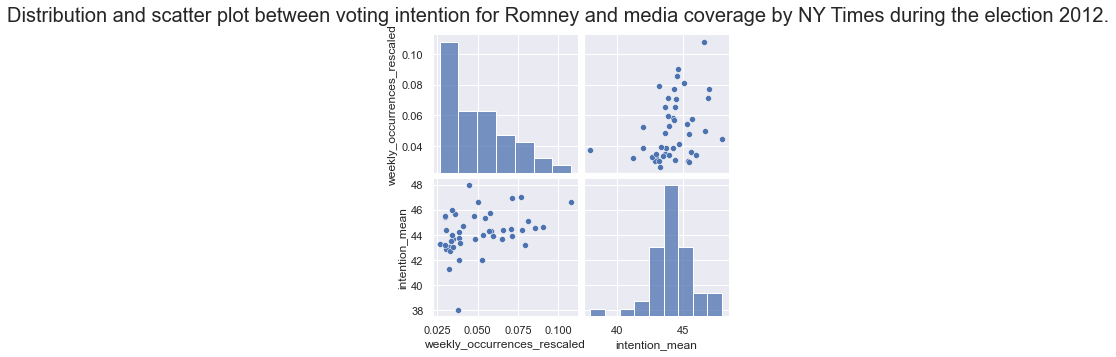

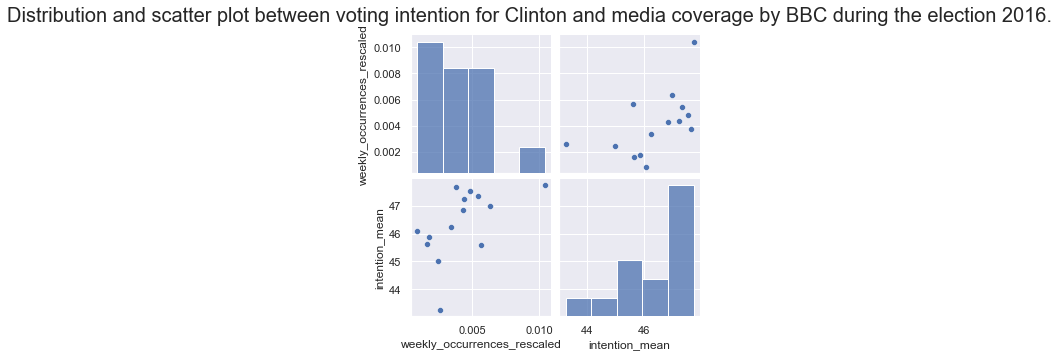

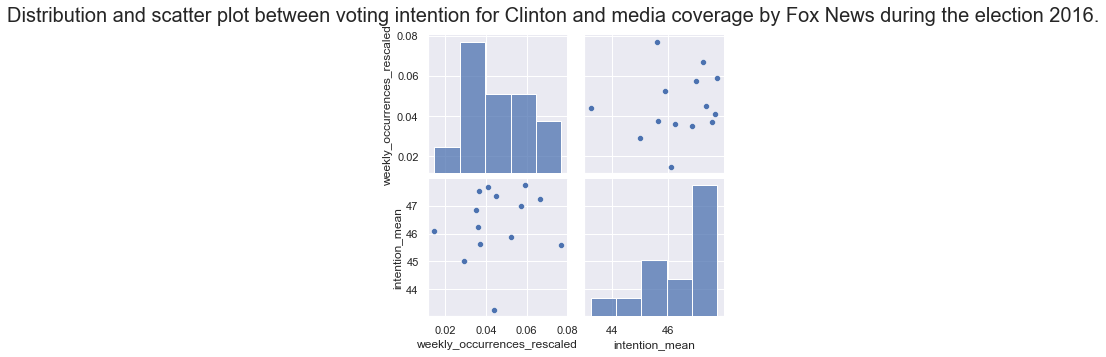

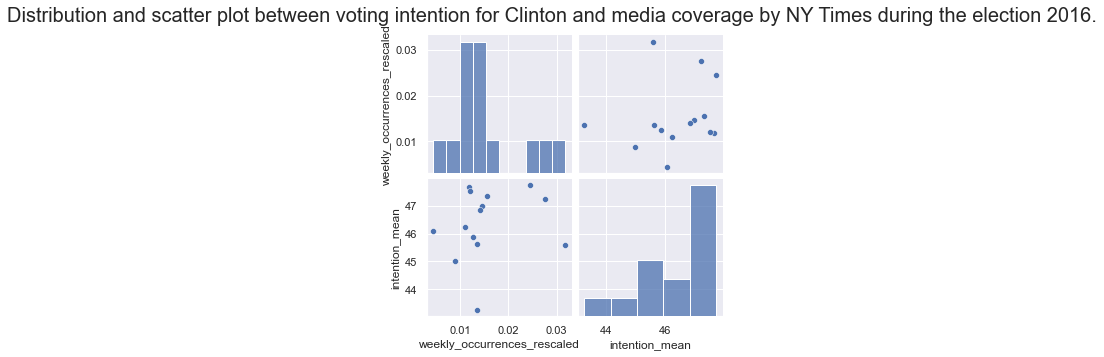

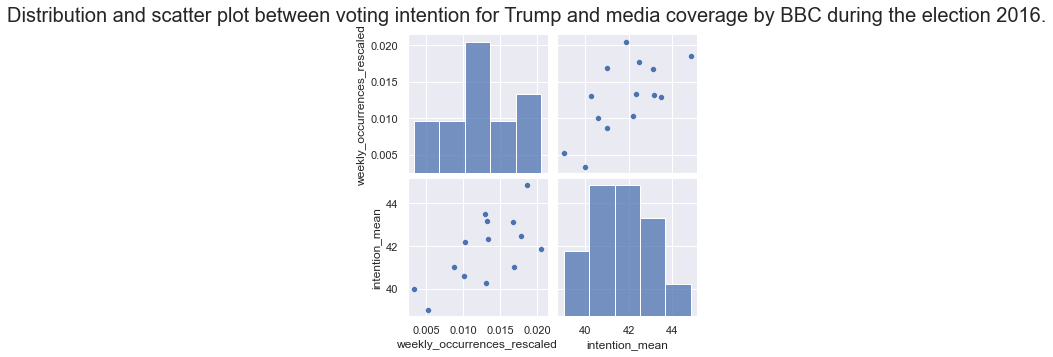

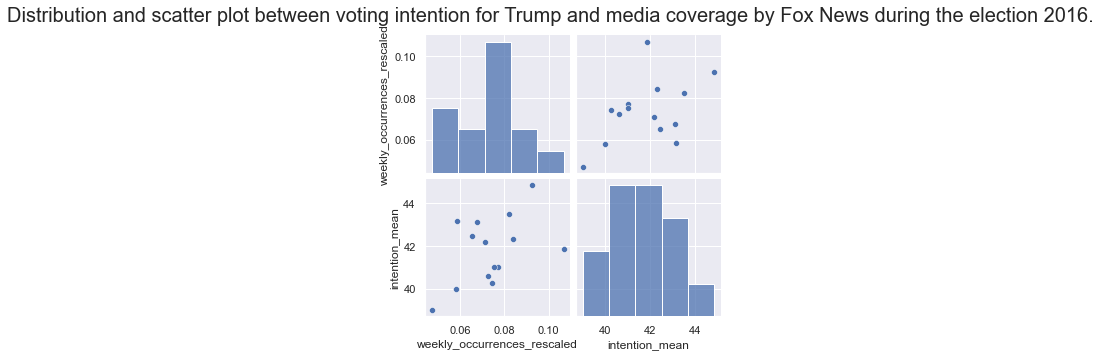

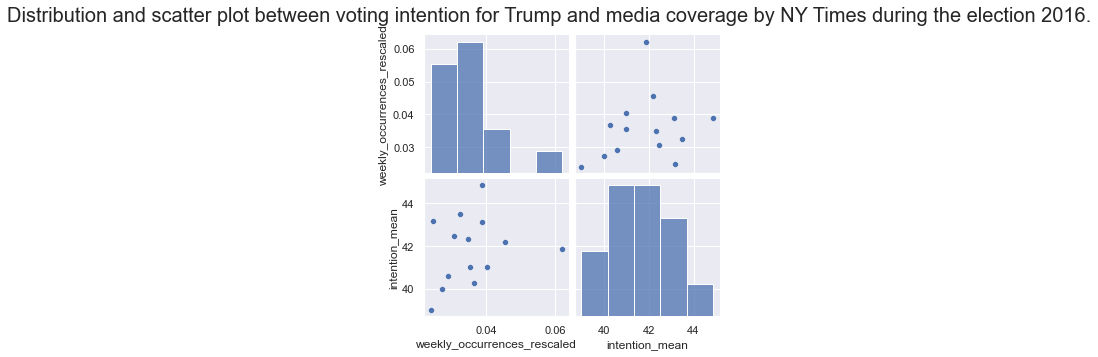

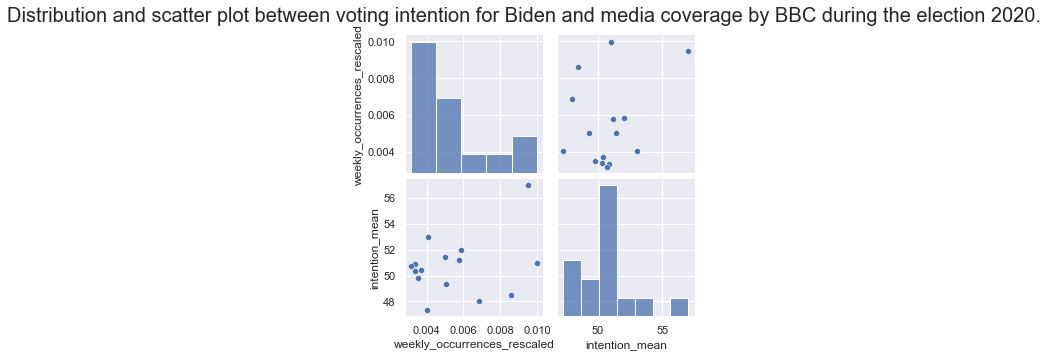

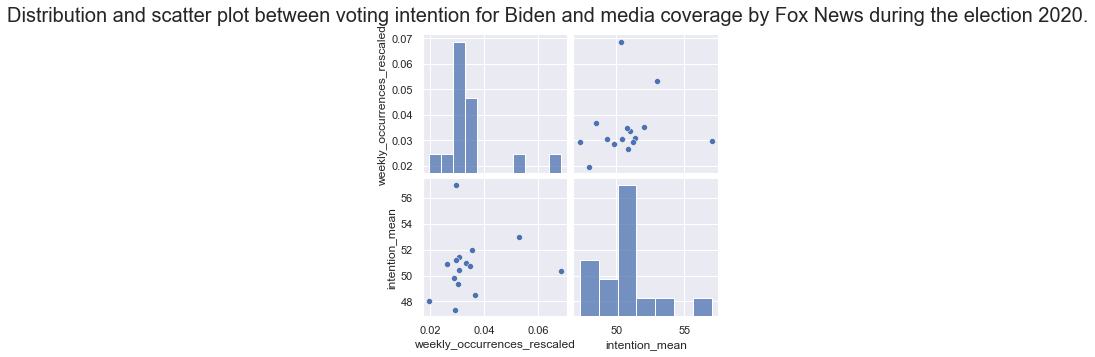

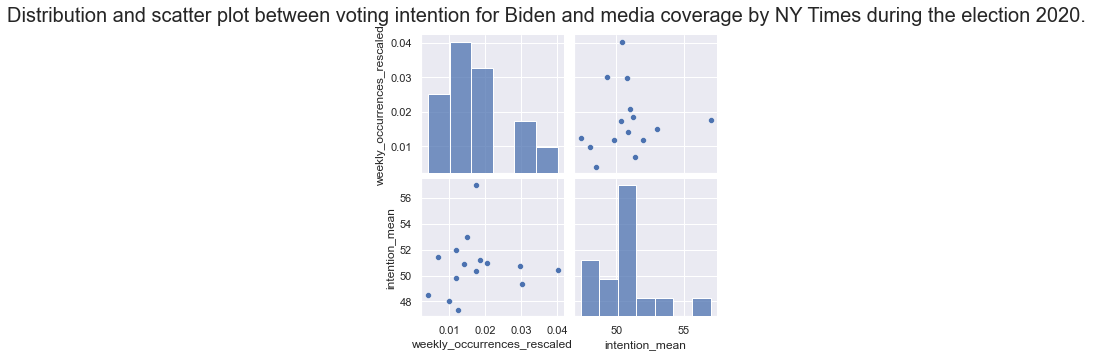

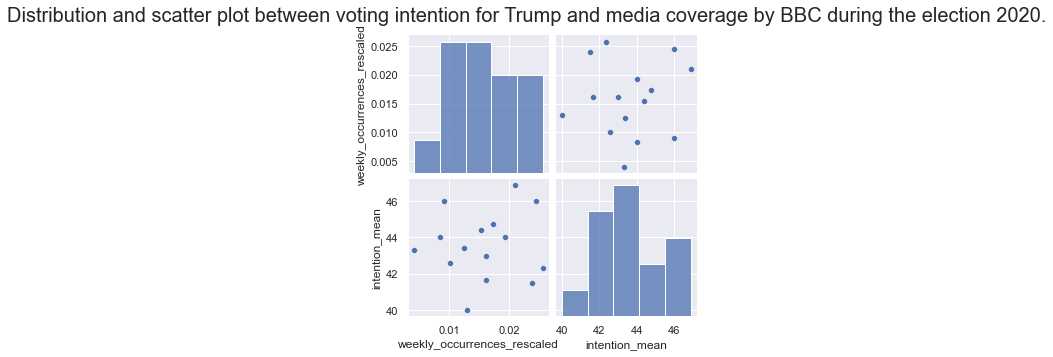

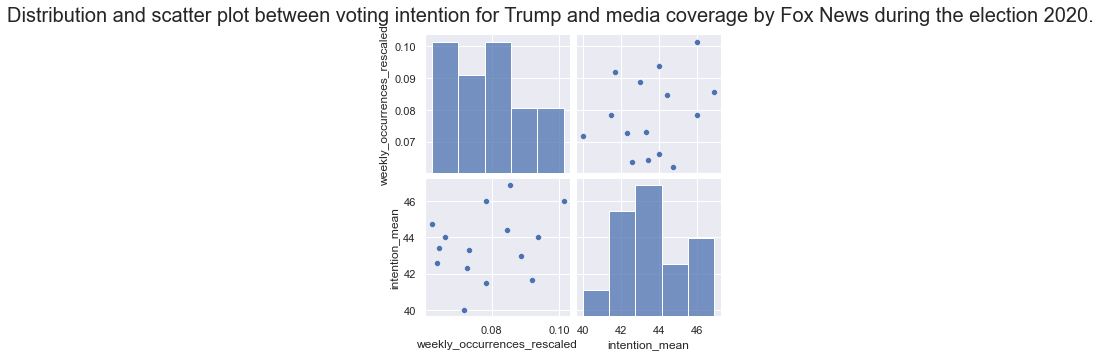

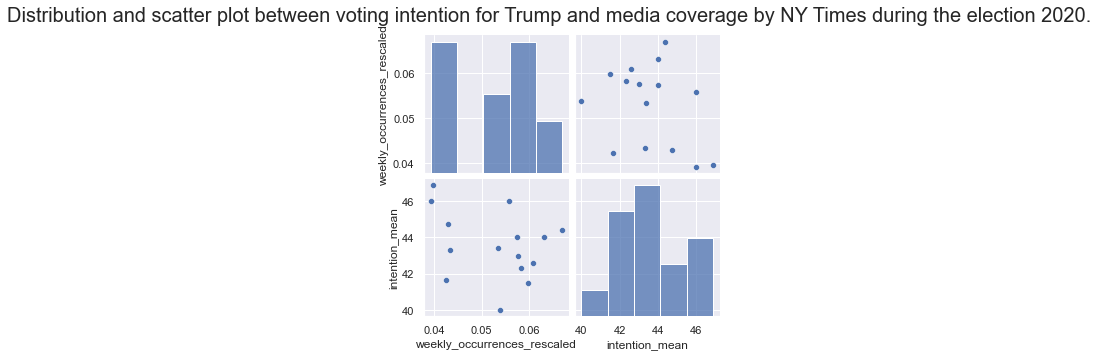

<IPython.core.display.Javascript object>

In [12]:
sns.set(font_scale=1)

for key in dict_wroi:
    df = dict_wroi[key]
    ax = sns.pairplot(df[["weekly_occurrences_rescaled", "intention_mean"]])
    ax.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
    ax.fig.suptitle(f"Distribution and scatter plot between voting intention for {key[1]} and media coverage by {key[2]} during the election {key[0]}.", fontsize=20)
    plt.show()

In [13]:
df_correlation = pd.DataFrame(columns=["Year", "Candidate", "Newspaper", "Spearmanr", "P-value"])

for key in dict_wroi:
    df = dict_wroi[key]
    row = baseline_model(df)
    row["Year"] = key[0]
    row["Candidate"] = key[1]
    row["Newspaper"] = key[2]
    df_correlation = df_correlation.append(row, ignore_index=True)

df_correlation

,Year,Candidate,Newspaper,Spearmanr,P-value
0,2012,Obama,BBC,-0.004879,0.974626
1,2012,Obama,Fox News,-0.176556,0.245973
2,2012,Obama,NY Times,-0.012592,0.934569
3,2012,Romney,BBC,0.292305,0.051361
4,2012,Romney,Fox News,0.495238,0.000543
5,2012,Romney,NY Times,0.379898,0.010052
6,2016,Clinton,BBC,0.578022,0.030383
7,2016,Clinton,Fox News,0.200000,0.493004
8,2016,Clinton,NY Times,0.208791,0.473779
9,2016,Trump,BBC,0.596260,0.024415


<IPython.core.display.Javascript object>

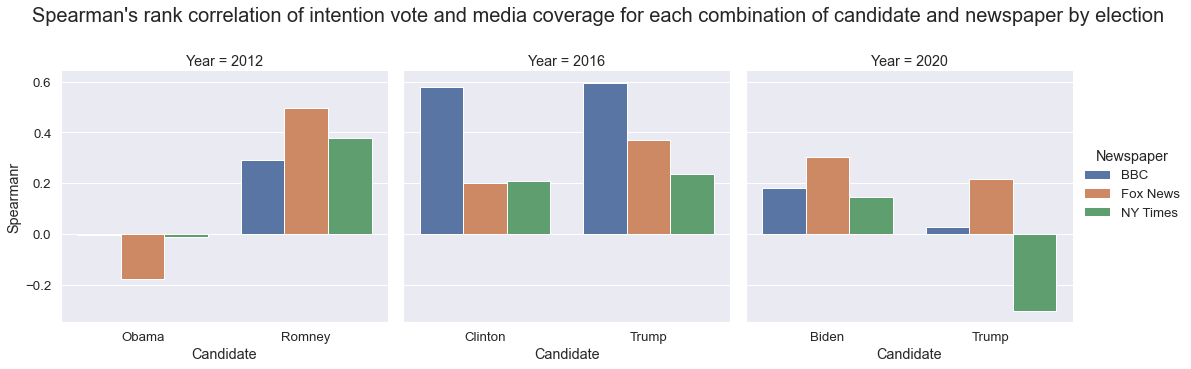

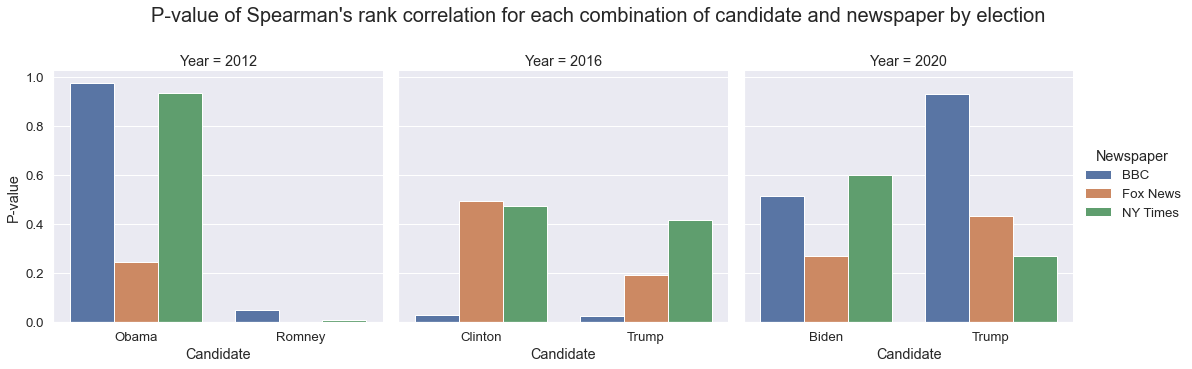

<IPython.core.display.Javascript object>

In [14]:
plot_combination("Spearmanr", "Spearman's rank correlation of intention vote and media coverage for each combination of candidate and newspaper by election")
plot_combination("P-value", "P-value of Spearman's rank correlation for each combination of candidate and newspaper by election")

Note that we will refer to the variable "intention_mean" by intention vote and "weekly_occurrences_rescaled" by media coverage.  
We can view our model as having intention vote as the dependent variable and media coverage as the predictor.  
Furthermore, we choose the Spearman's rank correlation, because the media coverage variable is not normally distributed.  
The second figure represents the p-values for the above correlations (must be smaller than 0.05 for the value to be statistically significant).  

Interpretation:
- 2012 election
    - Obama: Fox News produces some negative correlation between the two variable, but this result is not statistically significant (all values are higher than 0.1).
    - Romney: All three newspapers produces positive correlations between the two variable, this result is very good evidence (the p values are 0.051361, 0.000543 and 0.010052).
    - This may indicate that for Romney the media coverage had a positive impact, for Obama we cannot conclude. 
- 2016
    - Clinton: Almost no correlation for the three journals, no evidence that there is a correlation (all values are higher than 0.1).
    - Trump: Negative correlations in the three cases, in the NY times case the evidence is quite good (p is 0.023836), but for the other newspapers we have no evidence (values are higher than 0.1).
    - This may indicate that for Trump the media coverage had a negative impact, for Clinton we cannot conclude.
- 2020
    - Biden: Small positive correlation, no evidence of correlation (all values are higher than 0.1).
    - Trump: Small positive correlation and negative (for NY Times), no evidence of correlation (all values are higher than 0.1).
    - That result may be due to the lack of data for 2020 (quotations from Quotebank stops in April).

For 2012 and 2016 it seems that one of the candidates in each election seems to be positively correlated while the other is negatively correlated and that in only one case the evidence for correlation is good enough.  
For 2020 it is hard to conclude due to the lack of data.  
Also the media coverage of NY Time is greater than BBC and Fox News, which may be the reason why the p-value seems almost always smaller for NY Times.